In [1]:
import matplotlib.pyplot as plt
import astropy.units as u
import statistics as stat
import seaborn as sns
import thejoker as tj
import pandas as pd
import numpy as np
import arviz as az
import pymc as pm
import corner
import math 
import h5py


from astropy.visualization.units import quantity_support
from sklearn.metrics import mean_squared_error
from thejoker import JokerPrior, TheJoker, RVData
from thejoker.plot import plot_rv_curves
from scipy.stats import gaussian_kde
from os.path import join
from tqdm import tqdm

In [2]:
# Lee el archivo de texto y crea un DataFrame
nombres_columnas = ['Estrella', 'TYC', '2MASS']
data = pd.read_csv('Nombres_de_Estrellas.txt', delimiter=' ', names=nombres_columnas, header=None)  # Si el archivo está tabulado, usa '\t' como separador
data

,Estrella,TYC,2MASS
0,Krich_1,TYC22-591-1,2MASSJ01030596+0434459
1,Krich_2,TYC26-777-1,2MASSJ01194936+0634115
2,Na_rich,TYC6908-1643-1,2MASSJ20320320-2332524
3,Nrich_1,TYC4686-2039-1,2MASSJ01575297-0316508
4,Nrich_2,TYC8517-1671-1,2MASSJ05120630-5913438
5,Nrich_3,TYC244-273-1,2MASSJ10022398+0216045
6,Nrich_4,TYC250-1352-1,2MASSJ10071742+0605101
7,Nrich_5,TYC269-474-1,2MASSJ11173689+0645217
8,Nrich_6,TYC7408-694-1,2MASSJ18461977-3021506
9,Nrich_7,TYC5256-183-1,2MASSJ23513172-0312308


In [3]:
columns = ["Star","Date","RV","err_RV"]
Estrella = {}
mean = []
range = []
std = []
for i in data["Estrella"]:
    Estrella[i] = pd.read_csv(i+'.dat', delimiter='\t', names=columns, header=None)
    #print(Estrella[i])
    mean.append(np.mean(Estrella[i]["RV"]))
    range.append(np.max(Estrella[i]["RV"])-np.min(Estrella[i]["RV"]))
    std.append(np.std(Estrella[i]["RV"]))

In [4]:
Estrella["Nrich_1"]

,Star,Date,RV,err_RV
0,TYC4686-2039-1,2.459825e+06,147.1074,0.0208
1,TYC4686-2039-1,2.459874e+06,148.0102,0.0326
2,TYC4686-2039-1,2.459875e+06,148.9813,0.0673
3,TYC4686-2039-1,2.459875e+06,149.0065,0.0832


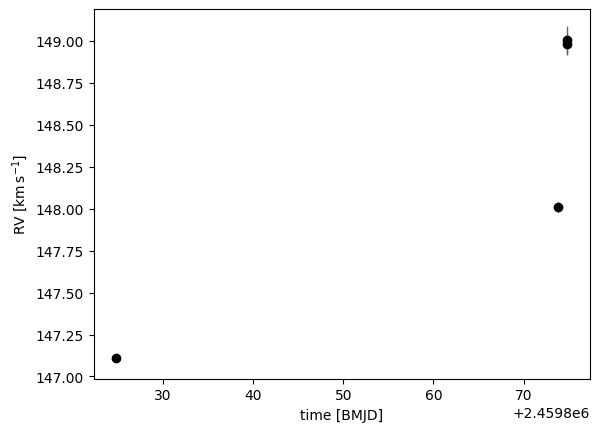

In [8]:
t = np.array(Estrella["Nrich_1"]["Date"])
rv = np.array(Estrella["Nrich_1"]["RV"]) * u.km/u.s
err = np.array(Estrella["Nrich_1"]["err_RV"]) * u.km/u.s
data = tj.RVData(t=t, rv=rv, rv_err=err)
ax = data.plot() 

In [9]:
data = RVData(t=t, rv=rv, rv_err=err)
prior = JokerPrior.default(P_min=46*u.day, P_max=50*u.day,sigma_K0=30 * u.km / u.s,sigma_v=100 * u.km / u.s)
joker = TheJoker(prior)
#46 a 50
print("Listo")

Listo


In [10]:
# rng = np.random.default_rng(seed=42) # pequeño retraso en el tiempo 
# prior_samples = prior.sample(size=1_500_000, rng=rng)

# print("Listo")

In [11]:
# prior_samples.write("prior_samples_Nrich1.hdf5", overwrite=True)

In [12]:
# samples = joker.rejection_sample(data, "prior_samples_Nrich1.hdf5", max_posterior_samples=1000)
# samples = samples.wrap_K()
# samples.write("samples_Nrich1.hdf5", overwrite=True)

In [13]:
samples = tj.JokerSamples.read("samples_Nrich1.hdf5")
samples_all = tj.JokerSamples.read("samples_Nrich1_all.hdf5")

samples,samples_all

(<JokerSamples [P, e, omega, M0, s, K, v0] (1000 samples)>,
 <JokerSamples [P, e, omega, M0, s, K, v0] (1000 samples)>)

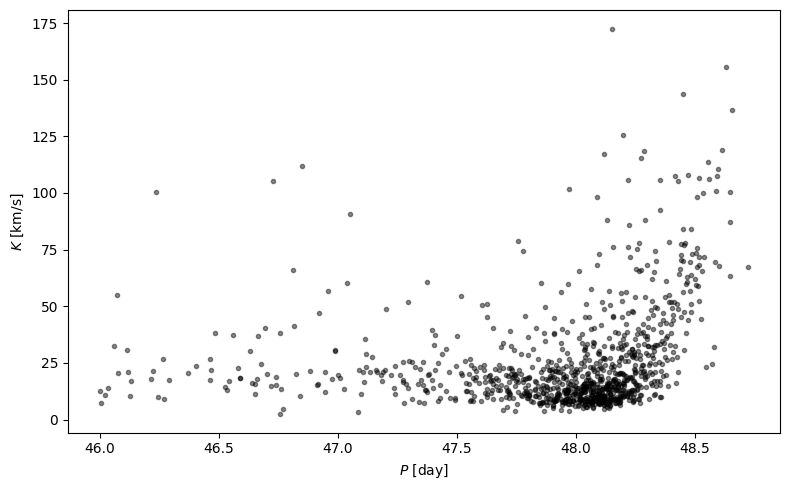

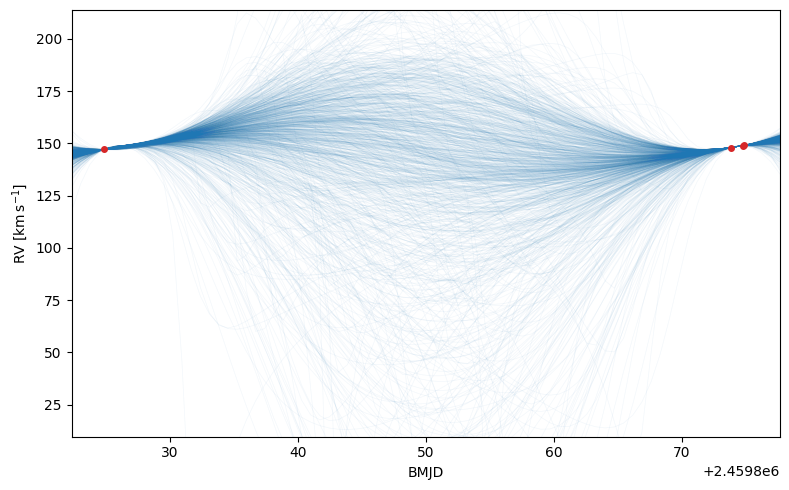

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5), layout="tight")
ax.scatter(samples['P'].value, samples['K'].to(u.km/u.s).value,marker='.', color='k', alpha=0.45)
#ax.set_ylim(0,20)
#plt.vlines(30.38,0,100)
ax.set_xlabel("$P$ [day]")
ax.set_ylabel("$K$ [km/s]")
fig, ax = plt.subplots(1, 1, figsize=(8, 5), layout="tight")


_ = tj.plot_rv_curves(samples,data=data,plot_kwargs=dict(color="tab:blue"),data_plot_kwargs=dict(color="tab:red"),relative_to_t_ref=False,ax=ax)



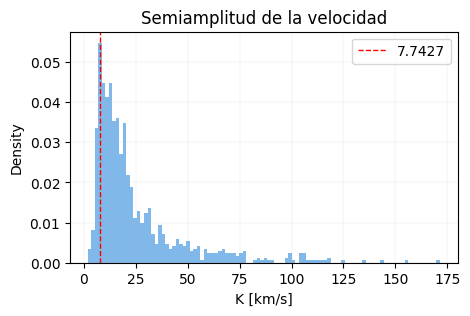

El pico más alto está en el valor: 7.7426714627831155


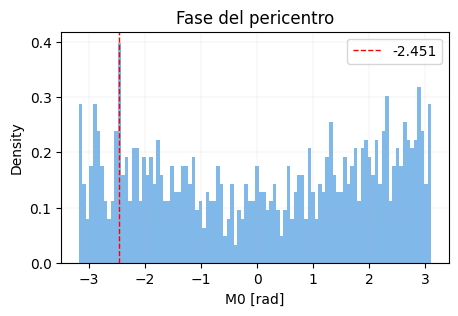

El pico más alto está en el valor: -2.4509567541830632


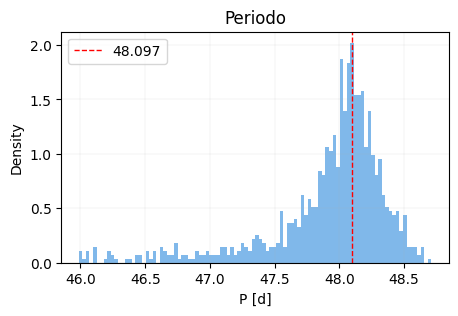

El pico más alto está en el valor: 48.09704454914771


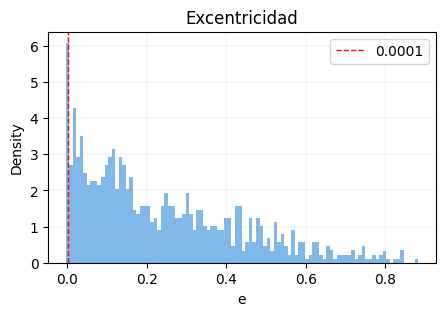

El pico más alto está en el valor: 0.00010160932609779302


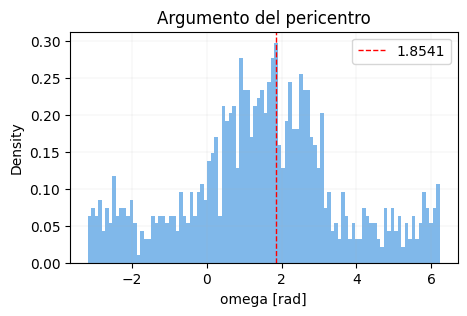

El pico más alto está en el valor: 1.8541153246900084


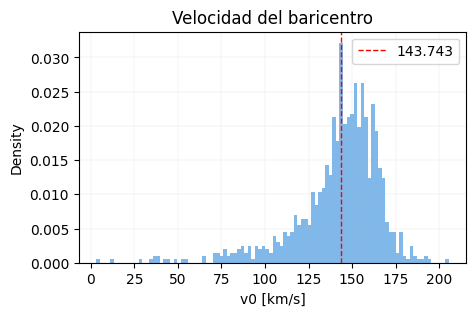

El pico más alto está en el valor: 143.74302564168565


In [15]:
variables = ["K","M0","P","e","omega","v0"]
xlabel = ["K [km/s]","M0 [rad]","P [d]","e","omega [rad]","v0 [km/s]"]
title = ["Semiamplitud de la velocidad","Fase del pericentro","Periodo","Excentricidad","Argumento del pericentro","Velocidad del baricentro"]
picos = []

for i in np.arange(len(variables)):
    plt.figure(figsize=(5,3))
    plt.ylabel("Density")
    plt.xlabel(xlabel[i])
    plt.title(title[i])
    conteos, bins, _  =  plt.hist(samples[variables[i]], bins = 100 ,density = True ,alpha=0.7, align = 'left', color = '#4B9BE2')
    
    plt.grid(linestyle='-', linewidth=0.1)
    
    # Encontrar el índice del valor máximo en los conteos
    indice_maximo = np.argmax(conteos)
    
    # Obtener el valor del pico más alto
    pico_mas_alto = bins[indice_maximo]
    picos.append(bins[indice_maximo])
    # Agregar una línea vertical en el pico más alto
    plt.axvline(x=pico_mas_alto, color='red', linestyle='--', linewidth = 1, label = f"{round(pico_mas_alto,4)}")
    
    
    # Mostrar el histograma con el pico más alto resaltado
    plt.legend()
    plt.show()
    
    print("El pico más alto está en el valor:", pico_mas_alto)


Text(0.5, 1.02, 'PairGrid of all dataset')

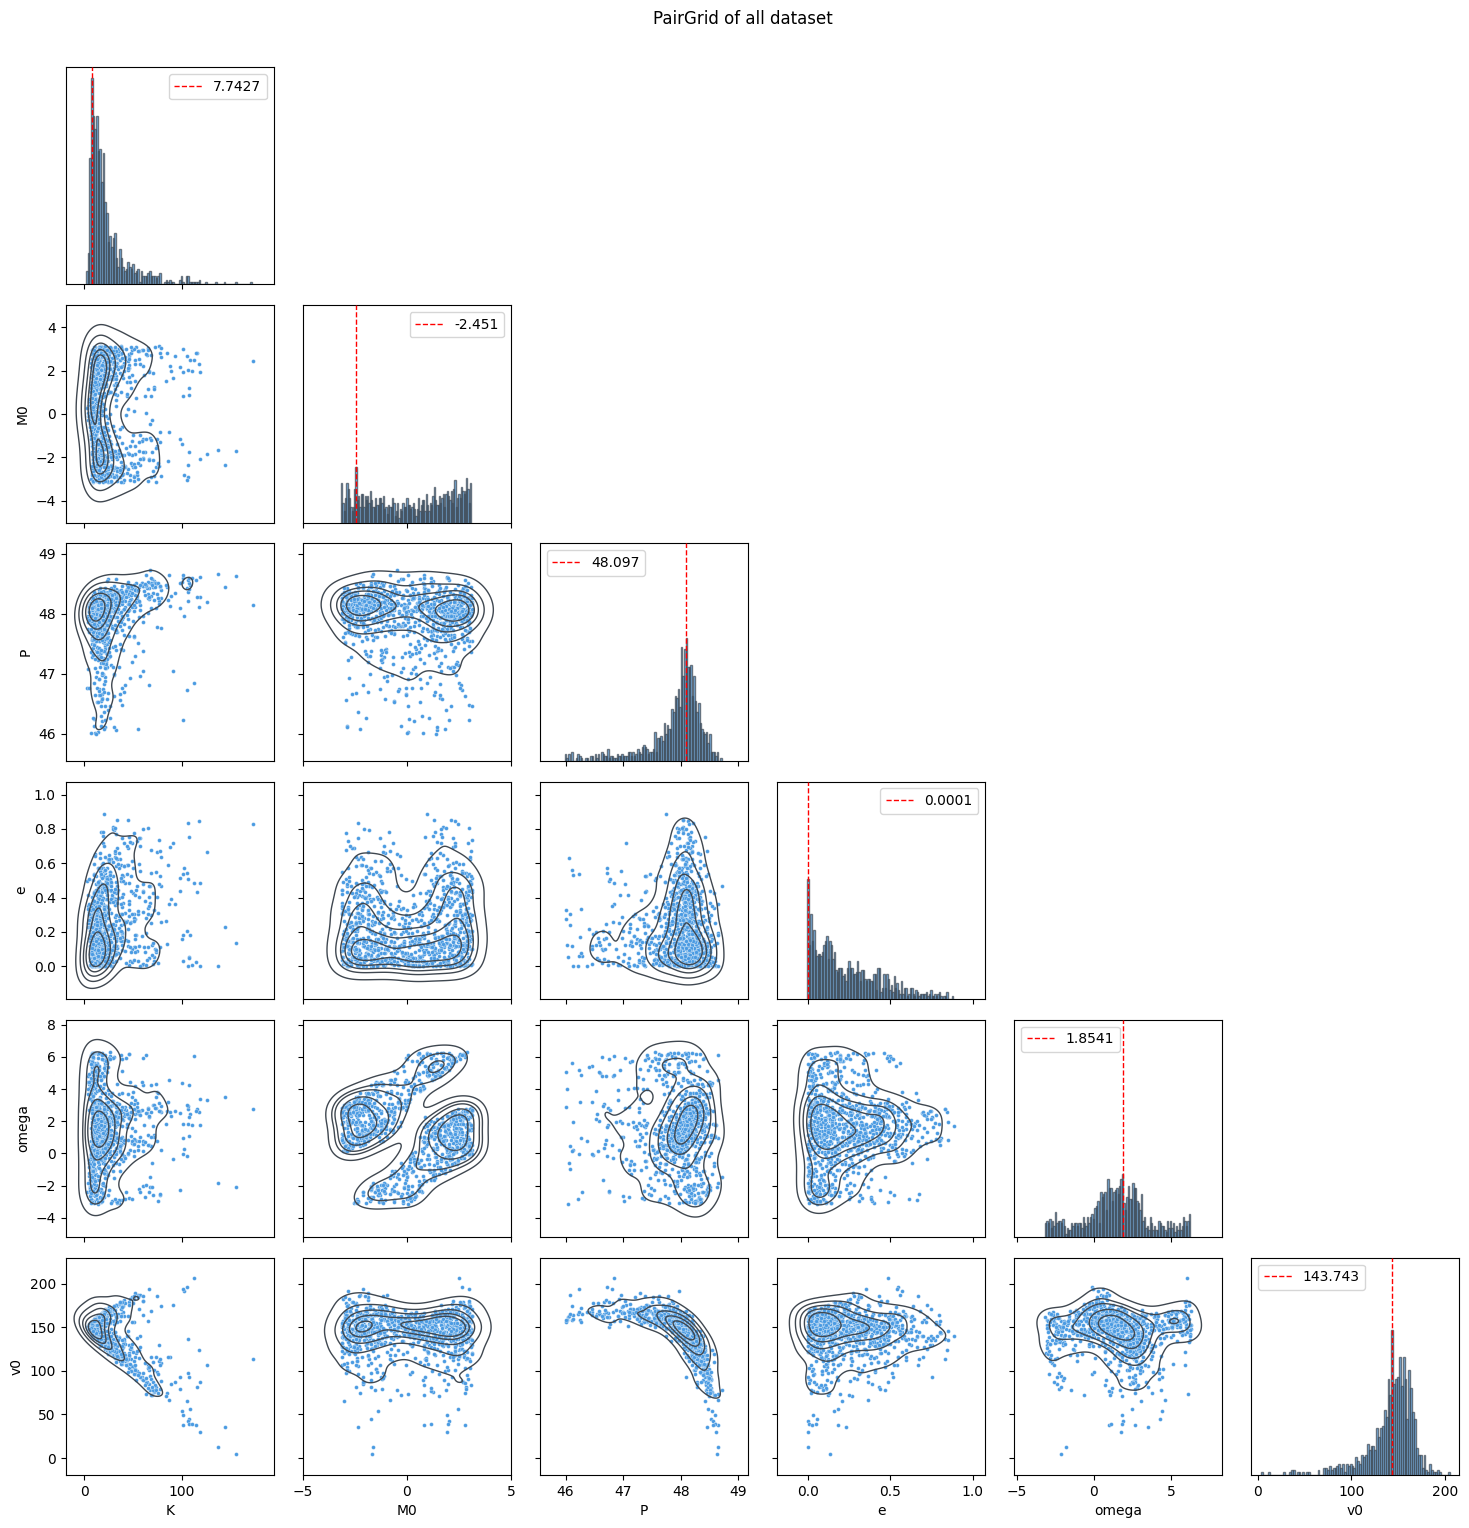

In [16]:
# Crear un gráfico de correlación utilizando pairplot
df = samples.tbl.to_pandas()
g = sns.PairGrid(df, 
            x_vars=["K", "M0", "P", "e", "omega", "v0"],
            y_vars=["K", "M0", "P", "e", "omega", "v0"],
            #plot_kws=dict(marker=".", linewidth=1),        # Edito los scatter
            #diag_kws=dict(fill=False),                     # Edito los histogramas
            corner=True)                                   # No muestra las de encima de la diagonal
# Mostrar el gráfico

g.map_diag(plt.hist,  bins = 100 ,density = False ,alpha=0.7, align = 'left', color = '#4B9BE2',edgecolor = '#3F4750')             #Histogramas en la diagonal
g.map_lower(sns.kdeplot,linewidths = 1, levels=6,  color="#3F4750",thresh=.1)             # Muestra los contornos
g.map_lower(sns.scatterplot,s = 8, color="#4B9BE2")                     # Muestra los puntos

# Añadir bordes y rejillas a cada cuadrícula
for ax in g.axes.flatten():
    if ax is not None:
        ax.spines['left'].set_visible(True)
        ax.spines['bottom'].set_visible(True)
        ax.spines['right'].set_visible(True)
        ax.spines['top'].set_visible(True)
        ax.grid(False)
        
# Agregar líneas verticales personalizadas en las diagonales
for i in np.arange(len(g.diag_axes)):
    ax = g.diag_axes[i]
    ax.axvline(x=picos[i], color='red', linestyle='--',linewidth = 1, label = f"{round(picos[i],4)}")
    ax.legend()
# Título del PairGrid
g.fig.suptitle("PairGrid of all dataset", y=1.02)

Text(0.5, 1.02, 'PairGrid of all dataset')

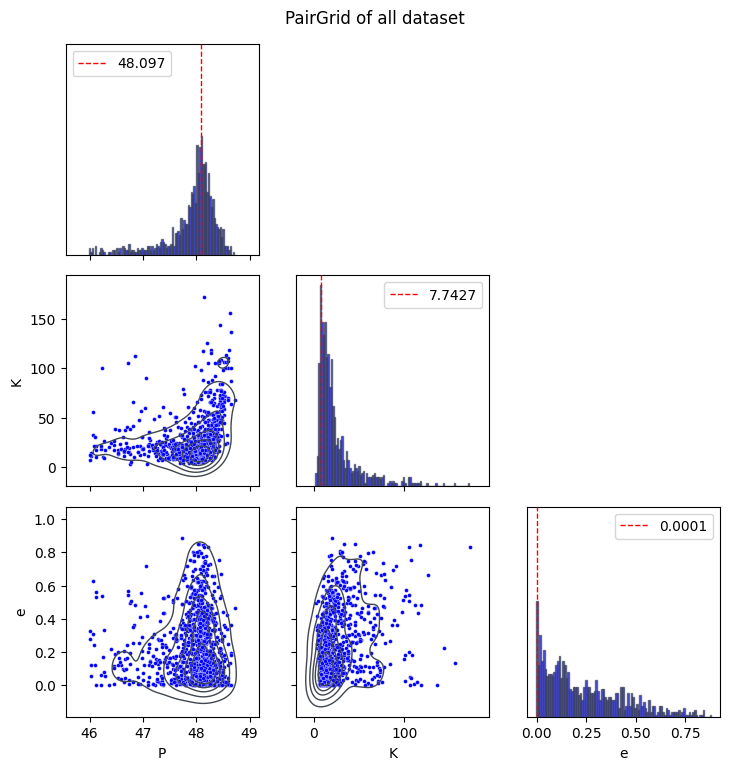

In [17]:
# Crear un gráfico de correlación utilizando pairplot
df = samples.tbl.to_pandas()
g = sns.PairGrid(df, 
            x_vars=["P","K", "e"],
            y_vars=["P","K", "e"],
            #plot_kws=dict(marker=".", linewidth=1),        # Edito los scatter
            #diag_kws=dict(fill=False),                     # Edito los histogramas
            corner=True)                                   # No muestra las de encima de la diagonal
# Mostrar el gráfico

g.map_diag(plt.hist,  bins = 100 ,density = False ,alpha=0.7, align = 'left', color = 'b',edgecolor = '#3F4750')             #Histogramas en la diagonal
g.map_lower(sns.kdeplot,linewidths = 1, levels=6,  color="#3F4750",thresh=.1)             # Muestra los contornos
g.map_lower(sns.scatterplot,s = 8, color="b")                     # Muestra los puntos

# Añadir bordes y rejillas a cada cuadrícula
for ax in g.axes.flatten():
    if ax is not None:
        ax.spines['left'].set_visible(True)
        ax.spines['bottom'].set_visible(True)
        ax.spines['right'].set_visible(True)
        ax.spines['top'].set_visible(True)
        ax.grid(False)
        
# Agregar líneas verticales personalizadas en las diagonales
pke = picos[2],picos[0],picos[3]
for i in np.arange(len(g.diag_axes)):
    ax = g.diag_axes[i]
    ax.axvline(x=pke[i], color='red', linestyle='--',linewidth = 1, label = f"{round(pke[i],4)}")
    ax.legend()
# Título del PairGrid
g.fig.suptitle("PairGrid of all dataset", y=1.02)

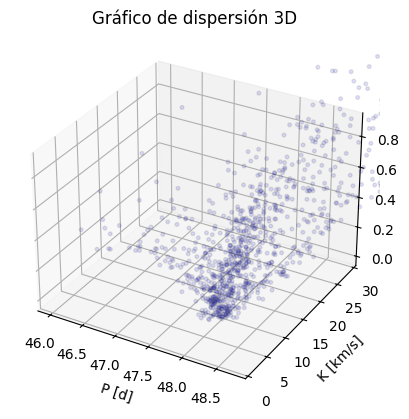

In [18]:
# Datos de muestra
fig = plt.figure()
ax = fig.add_subplot(projection = '3d')

ax.set_xlabel("P [d]")
ax.set_ylabel("K [km/s]")
ax.set_zlabel("e")
ax.set_ylim(0,30)
plt.title("Gráfico de dispersión 3D")

# Gráfico de dispersión 3D
ax.scatter(samples["P"], samples["K"], samples["e"],marker="o", s=7, color = "b", alpha=0.12, ec='#212325')

plt.show()

In [19]:
picos

[7.7426714627831155,
 -2.4509567541830632,
 48.09704454914771,
 0.00010160932609779302,
 1.8541153246900084,
 143.74302564168565]

In [20]:
P31 = samples[samples["K"].value<=30]

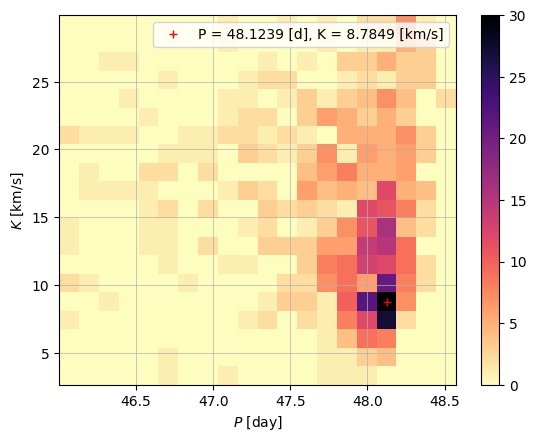

Coordenadas del valor más significativo:
x = 48.123922200371275
y = 8.784850587554105


In [21]:
bin=20

# Calcula el histograma bidimensional
hist, x_edges, y_edges = np.histogram2d(x=P31['P'].value, y=P31['K'].to(u.km/u.s).value, bins=bin)

# Encuentra las coordenadas del bin con el valor máximo en el histograma
max_index = np.unravel_index(np.argmax(hist), hist.shape)
x_max_density = (x_edges[max_index[0]] + x_edges[max_index[0] + 1]) / 2
y_max_density = (y_edges[max_index[1]] + y_edges[max_index[1] + 1]) / 2

# Grafica el histograma
fig, ax = plt.subplots()
h = ax.hist2d(x=P31['P'].value, y=P31['K'].to(u.km/u.s).value, bins=bin, cmap = "magma_r")
fig.colorbar(h[3], ax=ax)
ax.plot(x_max_density, y_max_density, "+", color="red", label=f"P = {round(x_max_density, 4)} [d], K = {round(y_max_density, 4)} [km/s]")
ax.set_xlabel("$P$ [day]")
ax.set_ylabel("$K$ [km/s]")
plt.grid(linestyle='-', linewidth=0.5)
plt.legend()
plt.show()

print("Coordenadas del valor más significativo:")
print("x =", x_max_density)
print("y =", y_max_density)

In [22]:
len(P31)

748

In [23]:
mask_P = (samples["P"].value>=47.9) & (samples["P"].value<=48.25)

Filtrado = samples[mask_P]
mask_K = (Filtrado["K"].value>=7) & (Filtrado["K"].value<=11)

Filtrado = Filtrado[mask_K]

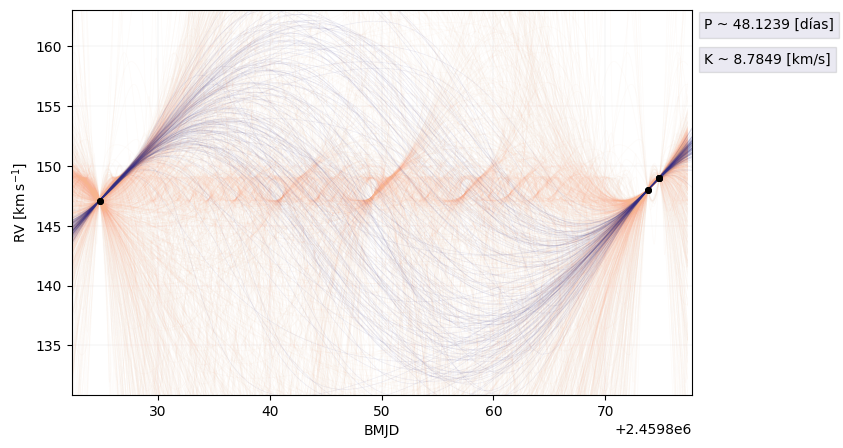

In [24]:
#fig = plt.figure(figsize=(8,10))
fig = plt.figure(figsize=(8,5))

gs = fig.add_gridspec(1, 1, hspace=0.02, wspace=0.05)
(ax1) = gs.subplots(sharex=True)


_ = tj.plot_rv_curves(samples_all,data=data,plot_kwargs=dict(color="#f7b48f"),data_plot_kwargs=dict(color="k"),relative_to_t_ref=False,ax=ax1, add_labels=True)
_ = tj.plot_rv_curves(Filtrado,data=data,plot_kwargs=dict(color="#322e82"),data_plot_kwargs=dict(color="k"),relative_to_t_ref=False,ax=ax1)

plt.text(1.02, 0.95, f'P ~ {round(x_max_density, 4)} [días]', transform = ax1.transAxes,bbox = {'facecolor': "#322e82", 'alpha': 0.1, 'pad': 4})
plt.text(1.02, 0.86, f'K ~ {round(y_max_density, 4)} [km/s]', transform = ax1.transAxes,bbox = {'facecolor': "#322e82", 'alpha': 0.1, 'pad': 4})

for ax in fig.get_axes():
    ax.label_outer()
    ax.grid(linestyle='-', linewidth=0.1)

#### Función de masa binaria
$$f(M) = \frac{M_2 \sin^3(i)}{(1+q)^2} = \frac{PK_1^3 (1-e^2)^{3/2}}{2\pi G}$$

Con $q = \frac{M_1}{M_2}$

In [25]:
# En nuestro caso

P = x_max_density*u.d 
e = picos[3] 
K = y_max_density*1000*u.m*1/u.s 

In [26]:
print("P =",P)
print("e =",e)
print("K =",K)

P = 48.123922200371275 d
e = 0.00010160932609779302
K = 8784.850587554105 m / s


In [27]:
def f(P,e,K):
    G = 6.67430e-11*(u.m)**3*1/u.kg * 1/u.s**2
    f = (P*K**3*(1-e**2)**(3/2))/(2*np.pi*G)
    f = f.cgs
    f = (f/(1.989e+33*u.g)*u.M_sun)
    return f

In [28]:
# Función de masa
f_value = f(P,e,K)
f_value

<Quantity 0.00337954 solMass>

In [29]:
M1 = 0.8*u.M_sun
sini =  1

In [30]:
# Ejemplo de uso
def resolver_ecuacion_cubica(a, b, c, d):
    coeficientes = [a, b, c, d]
    raices = np.roots(coeficientes)
    return raices
    
a = (sini)**3
b = -f_value.value
c = -2*M1.value*f_value.value
d = -M1.value**2*f_value.value

raices = resolver_ecuacion_cubica(a, b, c, d)
print("Las raíces de la ecuación son:", raices)

Las raíces de la ecuación son: [ 0.14445776+0.j         -0.07053911+0.09998407j -0.07053911-0.09998407j]


In [31]:
M2 = raices[0].real*u.M_sun
M_jupiter = 1.898e27*u.kg
print("La masa del objeto en M_Sun, M2 = ",M2)
print("La masa del objeto en kg, M2 = ",M2.to("kg"))
print("La masa del objeto en M_J, M2 = ",M2.to("M_jup"))
print("La masa del objeto en M_E, M2 = ",M2.to("M_earth"))

La masa del objeto en M_Sun, M2 =  0.14445775562764906 solMass
La masa del objeto en kg, M2 =  2.8724122718890432e+29 kg
La masa del objeto en M_J, M2 =  151.32896312077565 jupiterMass
La masa del objeto en M_E, M2 =  48096.64322030043 earthMass


Las **enanas marrones** son objetos subestelares que tienen más masa que los planetas gigantes gaseosos más grandes , pero menos que las estrellas menos masivas de la secuencia principal. Su masa es aproximadamente de $13 - 80$ veces la de Júpiter ( $M_J$ ) 

In [32]:
P_all = P31["P"]
e_all = P31["e"]
K_all = P31["K"].to(u.m/u.s)

# Función de masa
f_value_all = f(P_all,e_all,K_all)
f_value_all

<Quantity [3.21371685e-02, 1.89455213e-02, 6.68943887e-03, 8.23686658e-03,
           1.40931600e-02, 4.62786673e-02, 3.67319381e-02, 3.41518517e-02,
           8.50848916e-04, 3.81889374e-02, 1.19275773e-02, 4.74609105e-03,
           8.87301911e-03, 4.41331552e-02, 4.40722167e-02, 3.28552276e-03,
           1.80012722e-03, 5.04627799e-03, 1.40691982e-02, 1.78157152e-02,
           7.16894559e-04, 2.77852427e-03, 2.08552430e-02, 4.70971538e-03,
           1.65109540e-02, 7.43250362e-04, 5.19365399e-03, 2.48533156e-03,
           3.39329081e-03, 1.41127749e-03, 3.23422480e-02, 1.50011372e-02,
           3.65826678e-02, 1.45160986e-02, 2.22584922e-02, 1.23703237e-02,
           2.81492840e-02, 1.26917236e-02, 2.93569579e-03, 4.04559778e-03,
           1.21777843e-02, 1.19526609e-03, 2.28218760e-02, 2.27281484e-02,
           1.12145555e-02, 3.22509623e-03, 1.50606621e-02, 2.18762345e-03,
           4.83166137e-02, 3.20961746e-02, 8.49992447e-03, 9.51246948e-03,
           3.39818962e-03

In [33]:
a_all = [(sini)**3]*len(f_value_all.value)
b_all = -f_value_all.value
c_all = -2*M1.value*f_value_all.value
d_all = -M1.value**2*f_value_all.value

raices_all = []
M2_all = []
for i in np.arange(len(f_value_all)):
    raices_all = (resolver_ecuacion_cubica(a_all[i], b_all[i], c_all[i], d_all[i]))
    M2_all.append(((raices_all[0].real*u.M_sun).to("M_jup")).value)

In [34]:
P31_full = samples[samples["K"].value<=30]

P_all_full = samples["P"]
e_all_full = samples["e"]
K_all_full = samples["K"].to(u.m/u.s)

# Función de masa
f_value_all_full = f(P_all_full,e_all_full,K_all_full)
f_value_all_full

<Quantity [4.03253045e-01, 3.21371685e-02, 1.76798221e-01, 2.55735712e-01,
           2.57284442e-01, 1.89455213e-02, 6.68943887e-03, 8.23686658e-03,
           1.40931600e-02, 4.62786673e-02, 1.61470538e-01, 5.28933938e-01,
           1.88546662e-01, 1.07812433e+00, 3.67319381e-02, 3.41518517e-02,
           8.50848916e-04, 3.81889374e-02, 1.19275773e-02, 4.74609105e-03,
           8.87301911e-03, 1.73663050e-01, 4.41331552e-02, 1.94196883e+00,
           4.40722167e-02, 6.01783025e+00, 3.28552276e-03, 1.80012722e-03,
           5.04627799e-03, 1.40691982e-02, 1.78157152e-02, 7.16894559e-04,
           2.77852427e-03, 2.08552430e-02, 1.36174179e-01, 4.70971538e-03,
           1.65109540e-02, 7.43250362e-04, 1.29449365e-01, 5.19365399e-03,
           2.48533156e-03, 1.84092501e+01, 5.95141957e-01, 3.39329081e-03,
           1.41127749e-03, 3.23422480e-02, 1.50011372e-02, 9.15591798e-01,
           3.65826678e-02, 1.45160986e-02, 1.84704615e+00, 2.36613952e-01,
           2.22584922e-02

In [35]:
a_all_full = [(sini)**3]*len(f_value_all_full.value)
b_all_full = -f_value_all_full.value
c_all_full = -2*M1.value*f_value_all_full.value
d_all_full = -M1.value**2*f_value_all_full.value

raices_all_full = []
M2_all_full = []
for i in np.arange(len(f_value_all_full)):
    raices_all_full = (resolver_ecuacion_cubica(a_all_full[i], b_all_full[i], c_all_full[i], d_all_full[i]))
    M2_all_full.append(((raices_all_full[0].real*u.M_sun).to("M_jup")).value)

El pico más alto de la distribución está en: 170.3319689290991


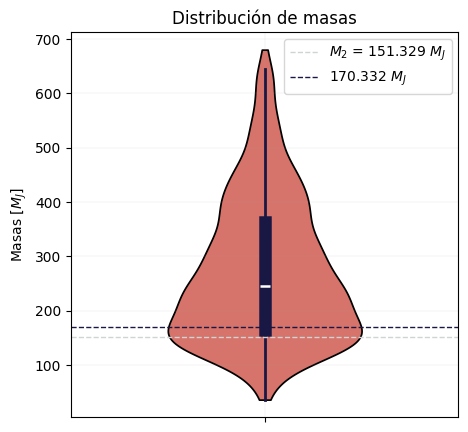

In [36]:
plt.figure(figsize=(5,5))
plt.title("Distribución de masas")


sns.violinplot(y = abs(np.array(M2_all)),inner_kws=dict(box_width=9, whis_width=2, color="#191743"),
               color = "#e3685c",saturation=0.8, fill=True, inner='box', split=False, width=0.5,
               dodge='auto', gap=0,density_norm='area',common_norm=False, bw_adjust=0.85,
              linecolor='k', cut=0, gridsize=250, native_scale=False)

# Calcula la densidad de la distribución
density = gaussian_kde(M2_all)

# Encuentra el rango de valores en el eje y
y_values = np.linspace(min(M2_all), max(M2_all), 1000)

# Evalúa la densidad en el rango de valores en el eje y
density_values = density(y_values)

# Encuentra el índice del máximo valor de densidad
peak_index = np.argmax(density_values)

# Encuentra el valor en el eje y correspondiente al pico
peak_value = y_values[peak_index]

print("El pico más alto de la distribución está en:", peak_value)

plt.axhline(y=M2.to("M_jup").value, color='#D0D3D4', linestyle='--',linewidth = 1, label = f'$M_2$ = { round(M2.to("M_jup").value,4)} $M_J$')
plt.axhline(y=peak_value, color='#191743', linestyle='--',linewidth = 1, label = f'{ round(peak_value,4)} $M_J$')

plt.ylabel("Masas [$M_J$]")
plt.legend()
plt.grid(linestyle='-', linewidth=0.1)
plt.show()

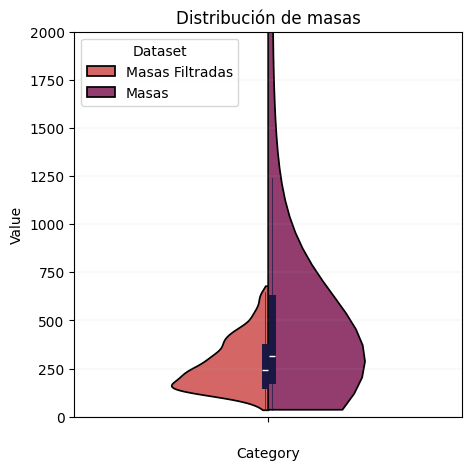

In [37]:
# Crear un DataFrame con las dos listas de datos
plt.figure(figsize=(5,5))
plt.title("Distribución de masas")

data = pd.DataFrame({
    'Value': M2_all + M2_all_full,
    'Dataset': ['Masas Filtradas'] * len(M2_all) + ['Masas'] * len(M2_all_full),
    'Category': ['  '] * len(M2_all) + ['  '] * len(M2_all_full)
})

# Crear el diagrama de violín con split=True usando la columna 'Category' para dividir los lados
sns.violinplot(x='Category', y='Value', hue='Dataset', data=data,inner_kws=dict(box_width=5, whis_width=0.5, color="#191743"),
               saturation=0.85, fill=True, inner='box', split=True, width=0.5,
               dodge='auto', gap=0,density_norm='area',common_norm=False, bw_adjust=0.85,
              linecolor='k', cut=0, gridsize=250, native_scale=False, palette = "flare")

# Ajustar el gráfico para que se vea mejor
plt.legend(loc='upper left',title='Dataset')
plt.ylim(0,2000)
plt.grid(linestyle='-', linewidth=0.1)
# Mostrar el gráfico
plt.show()

### <span style="color:red"> Potencial Binaria </span>  

### Estimación de la masa

In [134]:
B = 12.360 
V = 11.400
B_V = B-V
B_V

0.9599999999999991

#### Magnitud absoluta:

$$M = m - 5(log_{10}(d_{pc})-1)$$

In [135]:
m_V = V
d = np.mean([1293.810,1406.272,1307.8734,1138.96]) # Distancias encontradas en Simbad en pc
M=m_V-5*(np.log10(d)-1)
M

0.8525648076515715

#### Luminosidad

$$M = M_{\odot} - 2.5 \log_{10}\left(\frac{L}{L_{\odot}}\right)$$

$$L = 10^{-\frac{M-M_\odot}{2.5}}L_{\odot}$$

In [136]:
L=10**(-(M-4.83)/2.5)
L

38.9918711713353

In [137]:
masa = L**(1/3)
masa

3.3909758148752305